In [6]:

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [7]:
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
seller = pd.read_csv("olist_sellers_dataset.csv")
translate = pd.read_csv("product_category_name_translation.csv")


In [10]:

import googletrans
from googletrans import Translator

product["product_category_name_en"] = product["product_category_name"].map(lambda x: translator.translate(x, src="pt", dest="en").text)

ModuleNotFoundError: No module named 'googletrans'

In [ ]:
product.head()

In [14]:

df1 = order_items.merge(order_payments, on='order_id')
df2 = df1.merge(orders, on='order_id')
df3 = df2.merge(customers, on='customer_id')
df4 = df3.merge(product, on='product_id')
final_df = df4.merge(seller, on='seller_id')
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 33 columns):
order_id                         117601 non-null object
order_item_id                    117601 non-null int64
product_id                       117601 non-null object
seller_id                        117601 non-null object
shipping_limit_date              117601 non-null object
price                            117601 non-null float64
freight_value                    117601 non-null float64
payment_sequential               117601 non-null int64
payment_type                     117601 non-null object
payment_installments             117601 non-null int64
payment_value                    117601 non-null float64
customer_id                      117601 non-null object
order_status                     117601 non-null object
order_purchase_timestamp         117601 non-null object
order_approved_at                117586 non-null object
order_delivered_carrier_date     116356 non-null 

In [15]:
req_df= final_df[['order_id', 'order_item_id', 'product_id', 'product_category_name', 'order_purchase_timestamp', 'price',
                 'customer_unique_id', 'customer_id', 'seller_state' ]]

In [16]:
req_df.head()

,order_id,order_item_id,product_id,product_category_name,order_purchase_timestamp,price,customer_unique_id,customer_id,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,2017-09-13 08:59:02,58.9,871766c5855e863f6eccc05f988b23cb,3ce436f183e68e07877b285a838db11a,SP
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,2017-06-28 11:52:20,55.9,0fb8e3eab2d3e79d92bb3fffbb97f188,e6eecc5a77de221464d1c4eaff0a9b64,SP
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,2018-05-18 10:25:53,64.9,3419052c8c6b45daf79c1e426f9e9bcb,4ef55bf80f711b372afebcb7c715344a,SP
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,2017-08-01 18:38:42,58.9,e7c828d22c0682c1565252deefbe334d,30407a72ad8b3f4df4d15369126b20c9,SP
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,2017-08-10 21:48:40,58.9,0bb98ba72dcc08e95f9d8cc434e9a2cc,91a792fef70ecd8cc69d3c7feb3d12da,SP


In [18]:
req_df['InvoiceDate'] = pd.to_datetime(req_df['order_purchase_timestamp'])

In [20]:
req_df['InvoiceDate'].describe()

count                  117601
unique                  98111
top       2017-08-08 20:26:31
freq                       63
first     2016-09-04 21:15:19
last      2018-09-03 09:06:57
Name: InvoiceDate, dtype: object

In [21]:
df_10m = req_df[(req_df.InvoiceDate < date(2017,9,1)) & (req_df.InvoiceDate >= date(2017,1,1))].reset_index(drop=True)
df_next = req_df[(req_df.InvoiceDate >= date(2017,9,1)) & (req_df.InvoiceDate < date(2018,9,1))].reset_index(drop=True)

In [23]:
df_user = pd.DataFrame(df_10m['customer_unique_id'].unique())
df_user.columns = ['customer_unique_id']

In [24]:
#adding label

next_purchase_df= df_next.groupby('customer_unique_id').InvoiceDate.min().reset_index()

In [25]:
next_purchase_df.columns = ['customer_unique_id','MinPurchaseDate']

In [26]:
next_purchase_df.head()

,customer_unique_id,MinPurchaseDate
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16


In [27]:
last_purchase_df= df_10m.groupby('customer_unique_id').InvoiceDate.max().reset_index()

In [28]:
last_purchase_df.columns = ['customer_unique_id','MaxPurchaseDate']

In [29]:
purchase_dates_df = pd.merge(last_purchase_df,next_purchase_df,on='customer_unique_id',how='left')

In [30]:
purchase_dates_df['NextPurchaseDay'] = (purchase_dates_df['MinPurchaseDate'] - purchase_dates_df['MaxPurchaseDate']).dt.days

In [33]:
purchase_dates_df.tail()

,customer_unique_id,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
22057,fff1afc79f6b5db1e235a4a6c30ceda7,2017-08-30 23:38:43,NaT,NaN
22058,fff3a9369e4b7102fab406a334a678c3,2017-08-11 10:26:38,NaT,NaN
22059,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,NaT,NaN
22060,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,NaT,NaN
22061,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-02 20:18:45,NaT,NaN


In [34]:
df_user =  pd.merge(df_user, purchase_dates_df[['customer_unique_id','NextPurchaseDay']],on='customer_unique_id',how='left')

In [35]:
df_user.head()

,customer_unique_id,NextPurchaseDay
0,0fb8e3eab2d3e79d92bb3fffbb97f188,NaN
1,e7c828d22c0682c1565252deefbe334d,NaN
2,0bb98ba72dcc08e95f9d8cc434e9a2cc,NaN
3,33449409b16400dbeaf886a5140bf59c,NaN
4,840f10bde3c94907105e032d9c2fec3b,NaN


In [36]:
df_user = df_user.fillna(999)

In [38]:
df_user.head(100)

,customer_unique_id,NextPurchaseDay
0,0fb8e3eab2d3e79d92bb3fffbb97f188,999.0
1,e7c828d22c0682c1565252deefbe334d,999.0
2,0bb98ba72dcc08e95f9d8cc434e9a2cc,999.0
3,33449409b16400dbeaf886a5140bf59c,999.0
4,840f10bde3c94907105e032d9c2fec3b,999.0
5,0efd4833752113fedce2e7250d49d5ac,999.0
6,921fa6982e780da7d9e0bb6ca11b380c,999.0
7,89b88dc458d3997426620f99dd79c9c9,999.0
8,cef403f888f6bb14ec10e4e02e410893,999.0
9,f81c042ed0162a51b90372c233b4fbad,999.0


In [40]:
#Recency

max_purchase_df = df_10m.groupby('customer_unique_id').InvoiceDate.max().reset_index()

In [41]:
max_purchase_df.columns = ['customer_unique_id','MaxPurchaseDate']

In [42]:
max_purchase_df['Recency'] = (max_purchase_df['MaxPurchaseDate'].max() - max_purchase_df['MaxPurchaseDate']).dt.days

In [43]:
df_user = pd.merge(df_user, max_purchase_df[['customer_unique_id','Recency']], on='customer_unique_id')

In [44]:
df_user.head()

,customer_unique_id,NextPurchaseDay,Recency
0,0fb8e3eab2d3e79d92bb3fffbb97f188,999.0,64
1,e7c828d22c0682c1565252deefbe334d,999.0,30
2,0bb98ba72dcc08e95f9d8cc434e9a2cc,999.0,21
3,33449409b16400dbeaf886a5140bf59c,999.0,35
4,840f10bde3c94907105e032d9c2fec3b,999.0,26


In [45]:
df_user.Recency.describe()

count    22062.000000
mean        95.453676
std         62.749570
min          0.000000
25%         41.000000
50%         90.000000
75%        146.000000
max        238.000000
Name: Recency, dtype: float64

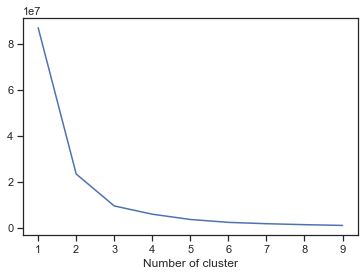

In [46]:
sse={}
user_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_recency)
    user_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [47]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [48]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [49]:
df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [50]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,5830.0,180.392453,24.275129,142.0,160.0,177.0,202.0,238.0
1,7522.0,102.808562,19.793121,68.0,86.0,102.0,119.0,141.0
2,8710.0,32.248565,19.229978,0.0,16.0,31.0,49.0,67.0


In [51]:
#FREQUENCY

user_frequency = df_10m.groupby('customer_unique_id').InvoiceDate.count().reset_index()
user_frequency.columns = ['customer_unique_id','Frequency']

user_frequency.head()


,customer_unique_id,Frequency
0,0000f46a3911fa3c0805444483337064,1
1,0005e1862207bf6ccc02e4228effd9a0,1
2,0006fdc98a402fceb4eb0ee528f6a8d4,1
3,000a5ad9c4601d2bbdd9ed765d5213b3,1
4,000de6019bb59f34c099a907c151d855,2


In [52]:
df_user = pd.merge(df_user, user_frequency, on='customer_unique_id')

In [53]:
df_user.head()

,customer_unique_id,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,0fb8e3eab2d3e79d92bb3fffbb97f188,999.0,64,2,1
1,e7c828d22c0682c1565252deefbe334d,999.0,30,2,1
2,0bb98ba72dcc08e95f9d8cc434e9a2cc,999.0,21,2,1
3,33449409b16400dbeaf886a5140bf59c,999.0,35,2,1
4,840f10bde3c94907105e032d9c2fec3b,999.0,26,2,2


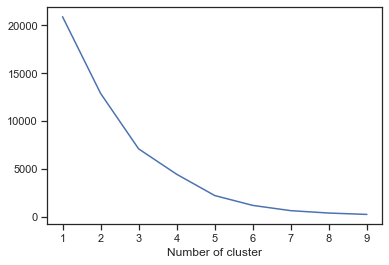

In [54]:
sse={}
user_frequency = df_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_frequency)
    user_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [56]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

In [57]:

df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,18723.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,382.0,4.780105,1.196593,4.0,4.0,4.0,5.0,10.0
2,1.0,75.000000,NaN,75.0,75.0,75.0,75.0,75.0
3,2931.0,2.139543,0.346571,2.0,2.0,2.0,2.0,3.0
4,25.0,15.800000,6.570134,11.0,11.0,13.0,19.0,35.0


In [59]:
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

In [61]:
req_df.columns


Index(['order_id', 'order_item_id', 'product_id', 'product_category_name',
       'order_purchase_timestamp', 'price', 'customer_unique_id',
       'customer_id', 'seller_state', 'InvoiceDate'],
      dtype='object')

In [62]:
#monetary value

df_10m['Revenue'] = df_10m['price'] * df_10m['order_item_id']


In [63]:
revenue_df = df_10m.groupby('customer_unique_id').Revenue.sum().reset_index()

In [64]:
revenue_df.head()

,customer_unique_id,Revenue
0,0000f46a3911fa3c0805444483337064,69.00
1,0005e1862207bf6ccc02e4228effd9a0,135.00
2,0006fdc98a402fceb4eb0ee528f6a8d4,13.90
3,000a5ad9c4601d2bbdd9ed765d5213b3,76.99
4,000de6019bb59f34c099a907c151d855,369.70


In [66]:
df_user = pd.merge(df_user, revenue_df, on='customer_unique_id')

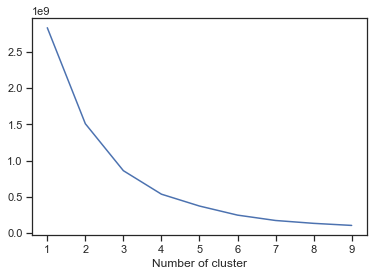

In [70]:
sse={}
revenue = df_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [71]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])

In [72]:
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

In [73]:
df_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,20494.0,107.532327,84.668942,3.90,45.000,84.90,145.575,405.90
1,1400.0,703.659407,263.304314,406.00,499.900,621.79,838.250,1559.55
2,153.0,2420.709281,793.620012,1576.84,1820.000,2130.00,2799.930,5298.00
3,15.0,8514.468000,3739.307794,5814.00,6569.585,7388.00,8339.000,20727.00


In [74]:
df_user.head()

,customer_unique_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,0fb8e3eab2d3e79d92bb3fffbb97f188,999.0,64,2,1,0,55.9,0
1,e7c828d22c0682c1565252deefbe334d,999.0,30,2,1,0,58.9,0
2,0bb98ba72dcc08e95f9d8cc434e9a2cc,999.0,21,2,1,0,58.9,0
3,33449409b16400dbeaf886a5140bf59c,999.0,35,2,1,0,55.9,0
4,921fa6982e780da7d9e0bb6ca11b380c,999.0,21,2,1,0,132.9,0


In [75]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']

In [76]:
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,180.263436,1.000000,99.451308
1,111.983557,1.099380,124.106922
2,45.100156,1.141778,139.943053
3,48.193426,2.106827,381.878515
4,52.951149,3.215517,811.887328
5,48.780952,5.447619,1584.974000
6,60.652174,8.869565,3070.459565
7,62.500000,16.666667,6458.701667
8,8.000000,20.000000,20727.000000


In [77]:
df_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    4726
1    6933
2    8337
3    1582
4     348
5     105
6      23
7       6
8       1
9       1
Name: Recency, dtype: int64

In [78]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value'

In [79]:
df_user.head()

,customer_unique_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,0fb8e3eab2d3e79d92bb3fffbb97f188,999.0,64,2,1,0,55.9,0,2,Low-Value
1,e7c828d22c0682c1565252deefbe334d,999.0,30,2,1,0,58.9,0,2,Low-Value
2,0bb98ba72dcc08e95f9d8cc434e9a2cc,999.0,21,2,1,0,58.9,0,2,Low-Value
3,33449409b16400dbeaf886a5140bf59c,999.0,35,2,1,0,55.9,0,2,Low-Value
4,921fa6982e780da7d9e0bb6ca11b380c,999.0,21,2,1,0,132.9,0,2,Low-Value


In [ ]:
####################

In [80]:
day_order = df_10m[['customer_unique_id','InvoiceDate']]

In [81]:
#Convert Invoice Datetime to day
day_order['InvoiceDay'] = df_10m['InvoiceDate'].dt.date

In [82]:
day_order = day_order.sort_values(['customer_unique_id','InvoiceDate'])

In [83]:
#Drop duplicates
day_order = day_order.drop_duplicates(subset=['customer_unique_id','InvoiceDay'],keep='first')

In [84]:
day_order.head()

,customer_unique_id,InvoiceDate,InvoiceDay
8308,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10
22785,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,2017-03-04
17401,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,2017-07-18
18591,000a5ad9c4601d2bbdd9ed765d5213b3,2017-08-11 13:45:15,2017-08-11
15090,000de6019bb59f34c099a907c151d855,2017-08-17 19:10:33,2017-08-17


In [85]:
#shifting last 3 purchase dates
day_order['1PrevInvoiceDate'] = day_order.groupby('customer_unique_id')['InvoiceDay'].shift(1)
day_order['2PrevInvoiceDate'] = day_order.groupby('customer_unique_id')['InvoiceDay'].shift(2)
day_order['3PrevInvoiceDate'] = day_order.groupby('customer_unique_id')['InvoiceDay'].shift(3)

In [88]:
day_order.head(500)

,customer_unique_id,InvoiceDate,InvoiceDay,1PrevInvoiceDate,2PrevInvoiceDate,3PrevInvoiceDate
8308,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10,NaN,NaN,NaN
22785,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,2017-03-04,NaN,NaN,NaN
17401,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,2017-07-18,NaN,NaN,NaN
18591,000a5ad9c4601d2bbdd9ed765d5213b3,2017-08-11 13:45:15,2017-08-11,NaN,NaN,NaN
15090,000de6019bb59f34c099a907c151d855,2017-08-17 19:10:33,2017-08-17,NaN,NaN,NaN
24833,0010a452c6d13139e50b57f19f52e04e,2017-07-11 11:22:43,2017-07-11,NaN,NaN,NaN
5734,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56,2017-08-31,NaN,NaN,NaN
19679,00115fc7123b5310cf6d3a3aa932699e,2017-01-21 21:58:35,2017-01-21,NaN,NaN,NaN
10805,0011805441c0d1b68b48002f1d005526,2017-04-24 13:36:48,2017-04-24,NaN,NaN,NaN
17236,0011857aff0e5871ce5eb429f21cdaf5,2017-06-28 11:08:38,2017-06-28,NaN,NaN,NaN


In [89]:
day_order['DayDiff'] = (day_order['InvoiceDay'] - day_order['1PrevInvoiceDate']).dt.days
day_order['DayDiff2'] = (day_order['InvoiceDay'] - day_order['2PrevInvoiceDate']).dt.days
day_order['DayDiff3'] = (day_order['InvoiceDay'] - day_order['3PrevInvoiceDate']).dt.days

In [90]:
day_order.head()

,customer_unique_id,InvoiceDate,InvoiceDay,1PrevInvoiceDate,2PrevInvoiceDate,3PrevInvoiceDate,DayDiff,DayDiff2,DayDiff3
8308,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10,NaN,NaN,NaN,NaN,NaN,NaN
22785,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,2017-03-04,NaN,NaN,NaN,NaN,NaN,NaN
17401,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,2017-07-18,NaN,NaN,NaN,NaN,NaN,NaN
18591,000a5ad9c4601d2bbdd9ed765d5213b3,2017-08-11 13:45:15,2017-08-11,NaN,NaN,NaN,NaN,NaN,NaN
15090,000de6019bb59f34c099a907c151d855,2017-08-17 19:10:33,2017-08-17,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
day_diff = day_order.groupby('customer_unique_id').agg({'DayDiff': ['mean','std']}).reset_index()
day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']
day_diff.head(20)

,CustomerID,DayDiffMean,DayDiffStd
0,0000f46a3911fa3c0805444483337064,NaN,NaN
1,0005e1862207bf6ccc02e4228effd9a0,NaN,NaN
2,0006fdc98a402fceb4eb0ee528f6a8d4,NaN,NaN
3,000a5ad9c4601d2bbdd9ed765d5213b3,NaN,NaN
4,000de6019bb59f34c099a907c151d855,NaN,NaN
5,0010a452c6d13139e50b57f19f52e04e,NaN,NaN
6,001147e649a7b1afd577e873841632dd,NaN,NaN
7,00115fc7123b5310cf6d3a3aa932699e,NaN,NaN
8,0011805441c0d1b68b48002f1d005526,NaN,NaN
9,0011857aff0e5871ce5eb429f21cdaf5,NaN,NaN


In [93]:
day_order_last = day_order.drop_duplicates(subset=['customer_unique_id'],keep='last')

In [94]:
day_order_last.head()

,customer_unique_id,InvoiceDate,InvoiceDay,1PrevInvoiceDate,2PrevInvoiceDate,3PrevInvoiceDate,DayDiff,DayDiff2,DayDiff3
8308,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10,NaN,NaN,NaN,NaN,NaN,NaN
22785,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,2017-03-04,NaN,NaN,NaN,NaN,NaN,NaN
17401,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,2017-07-18,NaN,NaN,NaN,NaN,NaN,NaN
18591,000a5ad9c4601d2bbdd9ed765d5213b3,2017-08-11 13:45:15,2017-08-11,NaN,NaN,NaN,NaN,NaN,NaN
15090,000de6019bb59f34c099a907c151d855,2017-08-17 19:10:33,2017-08-17,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
day_order_last = day_order_last.dropna()


In [100]:
class_df=df_user.copy()

In [101]:
class_df = pd.get_dummies(class_df)
class_df.tail()

,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,customer_unique_id_0000f46a3911fa3c0805444483337064,customer_unique_id_0005e1862207bf6ccc02e4228effd9a0,customer_unique_id_0006fdc98a402fceb4eb0ee528f6a8d4,customer_unique_id_000a5ad9c4601d2bbdd9ed765d5213b3,customer_unique_id_000de6019bb59f34c099a907c151d855,customer_unique_id_0010a452c6d13139e50b57f19f52e04e,customer_unique_id_001147e649a7b1afd577e873841632dd,customer_unique_id_00115fc7123b5310cf6d3a3aa932699e,customer_unique_id_0011805441c0d1b68b48002f1d005526,customer_unique_id_0011857aff0e5871ce5eb429f21cdaf5,customer_unique_id_0011c98589159d6149979563c504cb21,customer_unique_id_00191a9719ef48ebb5860b130347bf33,customer_unique_id_001926cef41060fae572e2e7b30bd2a4,customer_unique_id_001a2bf0e46c684031af91fb2bce149d,customer_unique_id_001f3c4211216384d5fe59b041ce1461,customer_unique_id_002043098f10ba39a4600b6c52fbfe3c,customer_unique_id_002b4cd83fabaffaa475f78ea5ef3e08,customer_unique_id_002d71b244beb91ca7030b15ab526446,customer_unique_id_002eb8b96288f3804e21d2777ac29895,customer_unique_id_003035f5ec76f2220098377482de93c9,customer_unique_id_00324c9f4d710e7bac5c5ba679714430,customer_unique_id_0036a074f98b80c4f1fc33dbbcf9c552,customer_unique_id_0036b4a3d09ad551a5188c2e374da402,customer_unique_id_0037d2bbb9ebc39d9114aea27ee16d72,customer_unique_id_0037eb1ff742ee2e71ba887f65f3c6f3,customer_unique_id_003e28cb6fab8a0901bff9229612375f,customer_unique_id_004288347e5e88a27ded2bb23747066c,customer_unique_id_0043d65f8039b4a4d43bc7b0f450ac2c,customer_unique_id_00444f48f6c9b55657e49435ce3a97ca,customer_unique_id_00446a03d7a34d191507c9e42870d0a5,customer_unique_id_0046311f458d8041b00063cb99482903,customer_unique_id_0047f3e16441284d757a8963344f6c59,customer_unique_id_0049dadc30da6a277c1e9d371df5a66f,customer_unique_id_0049db44bfd6cee26ac9c649329ff6ea,customer_unique_id_004ed862ea4e55f18868d3d782d10879,customer_unique_id_00522457bba00bba576a34fd9b4808fd,customer_unique_id_0055b522bc89cbfbf376d8b59a628470,customer_unique_id_0059acd36094bf670ec8b21be6c0044c,customer_unique_id_006d763076d74d16d66e828e79ec1544,customer_unique_id_00704e915ae0d4a236eace0267454cf9,customer_unique_id_00765d375af0e700f61c57db00a8ee63,customer_unique_id_0076a71311bb2386a353f5ba87d2aa29,...,customer_unique_id_ff922bdd6bafcdf99cb90d7f39cea5b3,customer_unique_id_ff95640b1b541ba71eaa077fd1853ca0,customer_unique_id_ff959aedd362b48bb97c0abeb0b36b62,customer_unique_id_ff9723b956508e1ce1e2f76b4fcdff54,customer_unique_id_ff983093f2d26e43569f7d58782faffb,customer_unique_id_ff9b12e78f7c6c8ad5327b63374c370c,customer_unique_id_ff9b8e5654b51a827582daf1051b1918,customer_unique_id_ff9bc66daa6702543b16f3c4897e300b,customer_unique_id_ff9c5dff16d7d6bfefc2acf5088d7b90,customer_unique_id_ff9d2f60401262b9da1e868f956fb2a8,customer_unique_id_ff9e11d25bd3a13105fbf416eee813c5,customer_unique_id_ff9ff869636c26565ded16038be5fa7d,customer_unique_id_ffa0ba4c9a6a0763879efe7c2b8d5b93,customer_unique_id_ffa17ff63f95ea3c838670e61d2666e0,customer_unique_id_ffa46fd1f769dfbdd6c039550b420949,customer_unique_id_ffa8c46ffe06ca740ae232f5966c5a01,customer_unique_id_ffaa5b5559566bb4dbf71d554310e760,customer_unique_id_ffafb9f09293653c2486abe52e5e05a4,customer_unique_id_ffba9f9dff87b05e310ecc46c8591044,customer_unique_id_ffbb866d7c0d272f9fe12de1b9ee9173,customer_unique_id_ffbb8dfaa0e54649d8690b85a3ef890d,customer_unique_id_ffbeaf37b7b79aaf8247735905f0863d,customer_unique_id_ffbf790cac0b6cf2e411d9f158c0fbe2,customer_unique_id_ffc04aafbf624bd130516cc1d195626a,customer_unique_id_ffc142edc6bce329c6df0006387a5a77,customer_unique_id_ffc9d8a98ebd09a78c8adb729c3cfa2a,customer_unique_id_ffcdafd7d9f69caf44c3aa1ff78c32b4,customer_unique_id_ffd44de1326179fff550dae07c6884c2,customer_unique_id_ffdcd85e0e81fc93f49bef4d54a4e61f,customer_unique_id_ffddff7cfa827d6c430ed9e373be416c,customer_unique_id_ffe254cc039740e17dd15a5305035928,customer_unique_id_ffe2dd1f3b0cbf0b5f35e818ec03c49b,customer_unique_id_ffe39c116d96cd81dcdfd9dcca

In [103]:
#0–20: Customers that will purchase in 0–20 days — Class name: 2
#21–49: Customers that will purchase in 21–49 days — Class name: 1
#≥ 50: Customers that will purchase in more than 50 days — Class name: 0

class_df['NextPurchaseDayRange'] = 2
class_df.loc[class_df.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
class_df.loc[class_df.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

In [104]:
class_df.NextPurchaseDayRange.value_counts()/len(df_user)

0    0.998187
1    0.001722
2    0.000091
Name: NextPurchaseDayRange, dtype: float64

In [105]:
class_df = class_df.drop('NextPurchaseDay',axis=1)

In [106]:
X, y = class_df.drop('NextPurchaseDayRange',axis=1), class_df.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [108]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [109]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.99784703 0.99830009]
NB [0.60815864 0.61162738]
RF [0.99807365 0.99830009]
SVC [0.99807365 0.99830009]
Dtree [0.99807365 0.99830009]
KNN [0.99807365 0.99830009]
